<a href="https://colab.research.google.com/github/sangsucki/ML-tutor/blob/main/4_Clustering_problem.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Chapter 04. 머신러닝 클러스터링 문제 연습하기

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Step 1. 분석할 데이터 불러오기

### 문제 01. 데이터 불러오기

In [ ]:
# 분석에 필요한 라이브러리를 불러옵니다
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns 

import warnings
warnings.filterwarnings('ignore')

In [ ]:
# prior 데이터는 분석에서 제외합니다.

base_path = '/content/drive/MyDrive/Colab Notebooks/머신러닝심화과정/data/instacart'
aisles = pd.read_csv(base_path + "/aisles.csv")
orders = pd.read_csv(base_path + "/orders.csv")
departments = pd.read_csv(base_path + "/departments.csv")
train = pd.read_csv(base_path + "/order_products__train.csv")[:100000]
products = pd.read_csv(base_path + "/products.csv")

### 문제 02. 데이터 미리보기

In [ ]:
# 데이터 크기 확인
print(aisles.shape, orders.shape, departments.shape, train.shape, products.shape)

# 데이터 일부 확인
display(aisles.head())
display(orders.head())
display(departments.head())
display(train.head())
display(products.head())

(134, 2) (3421083, 7) (21, 2) (100000, 4) (49688, 4)


,aisle_id,aisle
0,1,prepared soups salads
1,2,specialty cheeses
2,3,energy granola bars
3,4,instant foods
4,5,marinades meat preparation


,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,2539329,1,prior,1,2,8,NaN
1,2398795,1,prior,2,3,7,15.0
2,473747,1,prior,3,3,12,21.0
3,2254736,1,prior,4,4,7,29.0
4,431534,1,prior,5,4,15,28.0


,department_id,department
0,1,frozen
1,2,other
2,3,bakery
3,4,produce
4,5,alcohol


,order_id,product_id,add_to_cart_order,reordered
0,1,49302,1,1
1,1,11109,2,1
2,1,10246,3,0
3,1,49683,4,0
4,1,43633,5,1


,product_id,product_name,aisle_id,department_id
0,1,Chocolate Sandwich Cookies,61,19
1,2,All-Seasons Salt,104,13
2,3,Robust Golden Unsweetened Oolong Tea,94,7
3,4,Smart Ones Classic Favorites Mini Rigatoni Wit...,38,1
4,5,Green Chile Anytime Sauce,5,13


### 문제 03. 데이터 확인하기

In [ ]:
# aisles 데이터에서 결측치가 있는 column 확인하기
aisles.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 134 entries, 0 to 133
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   aisle_id  134 non-null    int64 
 1   aisle     134 non-null    object
dtypes: int64(1), object(1)
memory usage: 2.2+ KB


In [ ]:
# orders 데이터에서 결측치가 있는 데이터 확인하기
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3421083 entries, 0 to 3421082
Data columns (total 7 columns):
 #   Column                  Dtype  
---  ------                  -----  
 0   order_id                int64  
 1   user_id                 int64  
 2   eval_set                object 
 3   order_number            int64  
 4   order_dow               int64  
 5   order_hour_of_day       int64  
 6   days_since_prior_order  float64
dtypes: float64(1), int64(5), object(1)
memory usage: 182.7+ MB


In [ ]:
# departments 데이터에서 결측치가 있는 데이터 확인하기
departments.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21 entries, 0 to 20
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   department_id  21 non-null     int64 
 1   department     21 non-null     object
dtypes: int64(1), object(1)
memory usage: 464.0+ bytes


In [ ]:
# train 데이터에서 결측치가 있는 데이터 확인하기
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 4 columns):
 #   Column             Non-Null Count   Dtype
---  ------             --------------   -----
 0   order_id           100000 non-null  int64
 1   product_id         100000 non-null  int64
 2   add_to_cart_order  100000 non-null  int64
 3   reordered          100000 non-null  int64
dtypes: int64(4)
memory usage: 3.1 MB


In [ ]:
# products 데이터에서 결측치가 있는 데이터 확인하기
products.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49688 entries, 0 to 49687
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   product_id     49688 non-null  int64 
 1   product_name   49688 non-null  object
 2   aisle_id       49688 non-null  int64 
 3   department_id  49688 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 1.5+ MB


## Step 2. Data Preprocessing

- Instacart 데이터에는 결측치가 없습니다.

- 데이터를 분석하기 위한 대상을 정의하기 위해, 데이터를 합쳐봅니다.

### 문제 04. 데이터 병합하기

- 불러온 데이터들을 살펴보면, 테이블마다 특정_id를 기준으로 데이터를 병합할 수 있습니다.

- 이를 table join 연산이라고 하며 pandas의 pd.merge 함수를 이용하여 데이터를 모두 합쳐봅시다.

In [ ]:
# aisles과 products를 불러와봅니다.
display(aisles.head())
display(products.head())

,aisle_id,aisle
0,1,prepared soups salads
1,2,specialty cheeses
2,3,energy granola bars
3,4,instant foods
4,5,marinades meat preparation


,product_id,product_name,aisle_id,department_id
0,1,Chocolate Sandwich Cookies,61,19
1,2,All-Seasons Salt,104,13
2,3,Robust Golden Unsweetened Oolong Tea,94,7
3,4,Smart Ones Classic Favorites Mini Rigatoni Wit...,38,1
4,5,Green Chile Anytime Sauce,5,13


In [ ]:
# 두 테이블 모두 aisle_id를 가지고 있으므로, aisle_id를 기준으로 데이터를 합쳐봅니다.
temp = pd.merge(aisles, products, on="aisle_id")
temp

,aisle_id,aisle,product_id,product_name,department_id
0,1,prepared soups salads,209,Italian Pasta Salad,20
1,1,prepared soups salads,554,Turkey Chili,20
2,1,prepared soups salads,886,Whole Grain Salad with Roasted Pecans & Mango ...,20
3,1,prepared soups salads,1600,Mediterranean Orzo Salad,20
4,1,prepared soups salads,2539,Original Potato Salad,20
...,...,...,...,...,...
49683,134,specialty wines champagnes,47713,Sparkling Rose,5
49684,134,specialty wines champagnes,48984,Dry Sherry,5
49685,134,specialty wines champagnes,49438,Dry Fino Sherry,5
49686,134,specialty wines champagnes,49562,Blanc De Noirs Sparkling Wine,5


### 문제 05. 데이터 병합하기 2

In [ ]:
# 위에서 합친 temp와 합칠 수 있는 다른 테이블을 하나 더 가져옵니다.
display(temp.head())
display(departments.head())

,aisle_id,aisle,product_id,product_name,department_id
0,1,prepared soups salads,209,Italian Pasta Salad,20
1,1,prepared soups salads,554,Turkey Chili,20
2,1,prepared soups salads,886,Whole Grain Salad with Roasted Pecans & Mango ...,20
3,1,prepared soups salads,1600,Mediterranean Orzo Salad,20
4,1,prepared soups salads,2539,Original Potato Salad,20


,department_id,department
0,1,frozen
1,2,other
2,3,bakery
3,4,produce
4,5,alcohol


In [ ]:
temp = pd.merge(temp, departments, on="department_id")
temp

,aisle_id,aisle,product_id,product_name,department_id,department
0,1,prepared soups salads,209,Italian Pasta Salad,20,deli
1,1,prepared soups salads,554,Turkey Chili,20,deli
2,1,prepared soups salads,886,Whole Grain Salad with Roasted Pecans & Mango ...,20,deli
3,1,prepared soups salads,1600,Mediterranean Orzo Salad,20,deli
4,1,prepared soups salads,2539,Original Potato Salad,20,deli
...,...,...,...,...,...,...
49683,100,missing,49553,Organic Plain Skyr,21,missing
49684,100,missing,49575,Chocolate Vanilla Malt Custard,21,missing
49685,100,missing,49641,"8\"" Pecan Pie",21,missing
49686,100,missing,49664,Lemon Cayenne Drinking Vinegar,21,missing


### 문제 06. 데이터 병합하기 3

In [ ]:
# temp와 병합할 다른 테이블을 가져옵니다.
display(temp.head())
display(train.head())

,aisle_id,aisle,product_id,product_name,department_id,department
0,1,prepared soups salads,209,Italian Pasta Salad,20,deli
1,1,prepared soups salads,554,Turkey Chili,20,deli
2,1,prepared soups salads,886,Whole Grain Salad with Roasted Pecans & Mango ...,20,deli
3,1,prepared soups salads,1600,Mediterranean Orzo Salad,20,deli
4,1,prepared soups salads,2539,Original Potato Salad,20,deli


,order_id,product_id,add_to_cart_order,reordered
0,1,49302,1,1
1,1,11109,2,1
2,1,10246,3,0
3,1,49683,4,0
4,1,43633,5,1


In [ ]:
# 두 테이블이 공통으로 포함하고 있는 product_id를 기준으로 합칩니다.
temp = pd.merge(temp, train, on="product_id")
temp

,aisle_id,aisle,product_id,product_name,department_id,department,order_id,add_to_cart_order,reordered
0,1,prepared soups salads,209,Italian Pasta Salad,20,deli,36461,6,1
1,1,prepared soups salads,554,Turkey Chili,20,deli,47207,26,1
2,1,prepared soups salads,554,Turkey Chili,20,deli,56703,14,1
3,1,prepared soups salads,554,Turkey Chili,20,deli,58348,9,1
4,1,prepared soups salads,554,Turkey Chili,20,deli,131034,4,1
...,...,...,...,...,...,...,...,...,...
99995,100,missing,48865,Organic Ground Chicken,21,missing,86175,4,0
99996,100,missing,48865,Organic Ground Chicken,21,missing,107601,2,0
99997,100,missing,48865,Organic Ground Chicken,21,missing,160569,4,0
99998,100,missing,49406,Giant Roll Bath Tissue Essentials Strong Toile...,21,missing,27956,15,1


### 문제 07. 데이터 병합하기 4

In [ ]:
# temp와 병합할 데이터를 선택합니다.
display(temp.head())
display(orders.head())

,aisle_id,aisle,product_id,product_name,department_id,department,order_id,add_to_cart_order,reordered
0,1,prepared soups salads,209,Italian Pasta Salad,20,deli,36461,6,1
1,1,prepared soups salads,554,Turkey Chili,20,deli,47207,26,1
2,1,prepared soups salads,554,Turkey Chili,20,deli,56703,14,1
3,1,prepared soups salads,554,Turkey Chili,20,deli,58348,9,1
4,1,prepared soups salads,554,Turkey Chili,20,deli,131034,4,1


,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,2539329,1,prior,1,2,8,NaN
1,2398795,1,prior,2,3,7,15.0
2,473747,1,prior,3,3,12,21.0
3,2254736,1,prior,4,4,7,29.0
4,431534,1,prior,5,4,15,28.0


In [ ]:
# 두 데이터가 공통으로 포함하고 있는 order_id를 기준으로 데이터를 병합합니다.
temp = pd.merge(temp, orders, on="order_id")
temp

,aisle_id,aisle,product_id,product_name,department_id,department,order_id,add_to_cart_order,reordered,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,1,prepared soups salads,209,Italian Pasta Salad,20,deli,36461,6,1,50978,train,7,6,13,20.0
1,1,prepared soups salads,12398,Caprese Salad,20,deli,36461,7,0,50978,train,7,6,13,20.0
2,13,prepared meals,25407,Mashed Potatoes,20,deli,36461,5,0,50978,train,7,6,13,20.0
3,108,other creams cheeses,27323,Pure & Natural Sour Cream,16,dairy eggs,36461,1,1,50978,train,7,6,13,20.0
4,108,other creams cheeses,40593,Cream Cheese,16,dairy eggs,36461,11,1,50978,train,7,6,13,20.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,69,soup broth bouillon,16131,"Organic Chicken Noodle Soup, Reduced Sodium",15,canned goods,104392,1,0,70646,train,4,5,8,30.0
99996,69,soup broth bouillon,19436,Bone Organic Chicken with Ginger Broth,15,canned goods,104392,2,0,70646,train,4,5,8,30.0
99997,95,canned meat seafood,22168,Whole Maine Cherrystone Clams,15,canned goods,169122,1,1,55514,train,22,5,14,5.0
99998,100,missing,13339,Dairy Free Unsweetened Almond Milk Beverage,21,missing,229568,1,0,119863,train,5,5,14,25.0


### 문제 08. Customer 정의하기

- 모든 테이블을 병합한 temp table에서 Customer를 정의할 feature를 만듭니다.

- 고객들의 구매 내역을 기준으로 고객을 정의하려고 합니다.

- 이 때, 어떤 방식으로 고객을 정의해야할지 고민해보고 실습해봅시다.

In [ ]:
# 병합한 데이터 확인하기
temp

,aisle_id,aisle,product_id,product_name,department_id,department,order_id,add_to_cart_order,reordered,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,1,prepared soups salads,209,Italian Pasta Salad,20,deli,36461,6,1,50978,train,7,6,13,20.0
1,1,prepared soups salads,12398,Caprese Salad,20,deli,36461,7,0,50978,train,7,6,13,20.0
2,13,prepared meals,25407,Mashed Potatoes,20,deli,36461,5,0,50978,train,7,6,13,20.0
3,108,other creams cheeses,27323,Pure & Natural Sour Cream,16,dairy eggs,36461,1,1,50978,train,7,6,13,20.0
4,108,other creams cheeses,40593,Cream Cheese,16,dairy eggs,36461,11,1,50978,train,7,6,13,20.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,69,soup broth bouillon,16131,"Organic Chicken Noodle Soup, Reduced Sodium",15,canned goods,104392,1,0,70646,train,4,5,8,30.0
99996,69,soup broth bouillon,19436,Bone Organic Chicken with Ginger Broth,15,canned goods,104392,2,0,70646,train,4,5,8,30.0
99997,95,canned meat seafood,22168,Whole Maine Cherrystone Clams,15,canned goods,169122,1,1,55514,train,22,5,14,5.0
99998,100,missing,13339,Dairy Free Unsweetened Almond Milk Beverage,21,missing,229568,1,0,119863,train,5,5,14,25.0


- 한 명의 고객은 하나의 user_id를 가집니다. user_id 별로 데이터를 합쳐야 합니다.

- 각 user가 구매한 아이템 내역으로 간단하게 정의해보려고 합니다.

- user가 구매한 아이템은 products/aisles/departments 별로 정의가 되어있습니다.

- 가장 간단하게 표현할 수 있는 departments level로 표현해보겠습니다.

In [ ]:
# pd.crosstab 함수를 이용하여 데이터를 user_id당 departments별 구매 빈도로 변환합니다.
data = pd.crosstab(temp.user_id, temp.department)
data

department,alcohol,babies,bakery,beverages,breakfast,bulk,canned goods,dairy eggs,deli,dry goods pasta,...,household,international,meat seafood,missing,other,pantry,personal care,pets,produce,snacks
user_id,,,,,,,,,,,,,,,,,,,,,
30,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
55,0,0,1,1,0,0,0,2,1,0,...,0,0,0,0,0,0,0,0,2,4
56,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,6,2
66,0,0,0,0,1,0,0,1,0,0,...,0,0,0,0,0,3,0,0,2,0
79,0,0,1,0,0,0,0,3,0,0,...,0,0,0,0,0,0,0,0,6,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
206162,0,0,0,1,2,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,4
206171,0,0,0,1,0,0,0,1,0,0,...,0,0,0,0,0,0,3,0,0,0
206177,0,0,0,0,0,0,0,2,0,0,...,0,0,0,0,0,0,0,0,3,0


## Step 3. 클러스터링 적용하기

- 사용할 클러스터링 기법은 K-means와 Hierarchical Clustering 기법입니다.

- K-means와 Hierarchical clustering 방법별로 어떤 차이가 있는지 확인합니다.


- 클러스터링 기법에 사용할 성능 측정 지표는 Silhoutte score 입니다.

- Silhoette score는 -1에서 1 사이의 값을 가지며, 1일 때 best cluster를 가지고, -1일 때 worst cluster를 가집니다.

### 문제 09. K-means 클러스터링 적용하기

In [ ]:
# scikit-learn에서 Kmeans를 불러옵니다.
from sklearn.cluster import KMeans

model = KMeans()
preds = model.fit_predict(data)
preds

array([1, 4, 2, ..., 2, 1, 1], dtype=int32)

In [ ]:
np.unique(preds)

array([0, 1, 2, 3, 4, 5, 6, 7], dtype=int32)

* silhouette score: 실루엣 값은 개체가 다른 클러스터(seperation)에 비해 자신의 클러스터(cohesion)와 얼마나 유사한 지 측정합니다. 실루엣 범위는 -1에서 +1까지이며, 값이 높으면 객체가 자체 클러스터와 잘 일치하고 인접 클러스터와 잘 일치하지 않음을 나타냅니다. 

In [ ]:
# 성능 측정을 위해 silhouette score (range: -1 to 1 )를 불러옵니다
from sklearn.metrics import silhouette_score

score = silhouette_score(data, preds)
print("Silhouette Score: %.4f" % score)

Silhouette Score: 0.1844


### 문제 10. 최적의 클러스터 개수 찾기

- Kmeans는 K 개수에 따라 성능 편차가 심합니다.

- 최적의 K를 구하는 방법엔 어떤 것들이 있을까요?

In [ ]:
# inertia(Kmeans의 objective function값)을 계산해서 K값이 변화함에 따라 inertia의 변화가 가장 커지는 K를 찾습니다.
# K의 범위는 확인하고 싶은 모든 범위를 지정하면 됩니다. 실습에서는 2 ~ 10으로 하겠습니다.

errors = []

for K in range(2, 11):
    temp_model = KMeans(n_clusters=K)
    temp_model.fit(data)
    sse = temp_model.inertia_
    errors.append(sse)

* Inertia value는 군집화가된 후에, 각 중심점에서 군집의 데이타간의 거리를 합산한것이으로 군집의 응집도를 나타내는 값이다, 이 값이 작을 수록 응집도가 높게 군집화가 잘되었다고 평가할 수 있다.

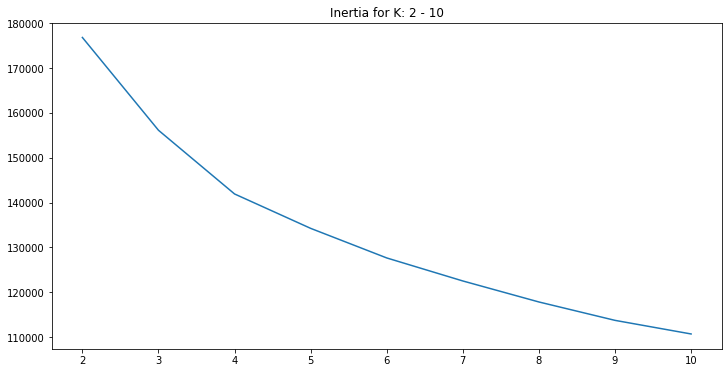

In [ ]:
plt.figure(figsize=(12, 6))
plt.title("Inertia for K: 2 - 10")
plt.plot(list(range(2, 11)), errors)
plt.show()

### 문제 11. 최적의 클러스터 개수 찾기 2

- 이번에는 inertia 대신에 silhouette score를 이용하여 최적의 K를 찾아봅시다.

In [ ]:
scores = []

for K in range(2, 11):
    temp_model = KMeans(n_clusters=K)
    preds = temp_model.fit_predict(data)
    scores.append(silhouette_score(data, preds))

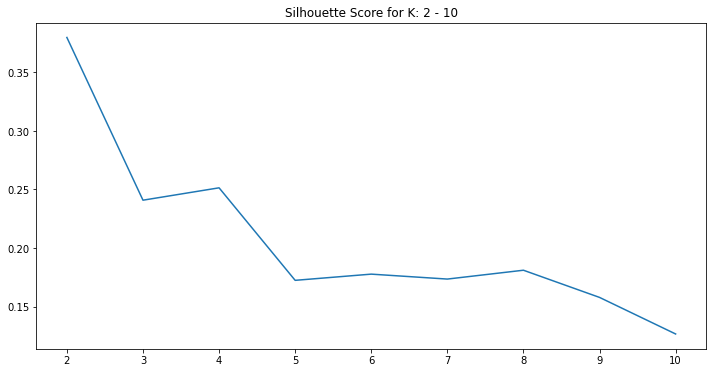

In [ ]:
plt.figure(figsize=(12, 6))
plt.title("Silhouette Score for K: 2 - 10")
plt.plot(list(range(2, 11)), scores)
plt.show()

- **silhouette을 기준으로 했을 때 최적의 K는 2입니다.**

### 문제 12. Hierarchical Clustering 돌려보기

- hierarchical clustering은 K-means와 전혀 다른 방법으로 동작합니다.

- hierarchical clustering은 distance measure와 linkage method를 변경하는 것으로 다양한 형태의 클러스터를 판별할 수 있습니다.

In [ ]:
# hierarchical clustering 함수를 scikit-learn에서 불러오기
from sklearn.cluster import AgglomerativeClustering

hierarchical_model = AgglomerativeClustering()
preds = hierarchical_model.fit_predict(data)
preds

array([0, 0, 0, ..., 0, 0, 0])

In [ ]:
np.unique(preds)

array([0, 1])

In [ ]:
# 성능 측정을 위해 silhouette score를 계산합니다.
score = silhouette_score(data, preds)
print("Silhouette Score: %.4f" % score)

Silhouette Score: 0.3829


## 문제 13. linkage 바꿔보기

- Hierarchical clustering은 linkage(연결 방식)을 변경하여 댜양한 형태의 데이터를 파악할 수 있습니다.

- 각 방식을 scikit-learn으로 구현하여 봅시다.

In [ ]:
# clustering model with various linkage method
model_single = AgglomerativeClustering(linkage="single")
model_average = AgglomerativeClustering(linkage="average")
model_complete = AgglomerativeClustering(linkage="complete")
model_ward = AgglomerativeClustering(linkage="ward") # default

pred_single = model_single.fit_predict(data)
pred_average = model_average.fit_predict(data)
pred_complete = model_complete.fit_predict(data)
pred_ward = model_ward.fit_predict(data)

## 문제 14. 성능 비교

- scikit-learn이 제공하는 4가지의 linkage 방법을 비교하여 성능을 확인하여 봅니다.

In [ ]:
# 성능 측정을 위해 silhouette score를 계산합니다.
score_single = silhouette_score(data, pred_single)
score_average = silhouette_score(data, pred_average)
score_complete = silhouette_score(data, pred_complete)
score_ward = silhouette_score(data, pred_ward)
print("Silhouette Score with single linkage: %.4f" % score_single)
print("Silhouette Score with average linkage: %.4f" % score_average)
print("Silhouette Score with complete linkage: %.4f" % score_complete)
print("Silhouette Score with ward linkage: %.4f" % score_ward)

Silhouette Score with single linkage: 0.6896
Silhouette Score with average linkage: 0.7711
Silhouette Score with complete linkage: 0.7711
Silhouette Score with ward linkage: 0.3829


### 문제 15. distance measure 바꿔보기

- Hierarchical clustering의 장점 중에 하나는 다양한 거리 함수를 사용할 수 있다는 것입니다.

- "affinity=" 파라미터를 변경하여 다른 거리 함수로 클러스터링을 시도하고 성능을 비교하여 봅시다.

- "ward linkage"는 euclidean distance만 가능하므로, linkage는 average로 변경하여 

In [ ]:
# hierarchical clustering
model_l1 = AgglomerativeClustering(affinity="manhattan", linkage="average")
model_l2 = AgglomerativeClustering(affinity="euclidean", linkage="average") # default
model_cos = AgglomerativeClustering(affinity="cosine", linkage="average")

# prediction
pred_l1 = model_l1.fit_predict(data)
pred_l2 = model_l2.fit_predict(data)
pred_cos = model_cos.fit_predict(data)

### 문제 16. 성능 비교

In [ ]:
# 성능 측정을 위해 silhouette score를 계산합니다.
score_l1 = silhouette_score(data, pred_l1)
score_l2 = silhouette_score(data, pred_l2)
score_cos = silhouette_score(data, pred_cos)

print("Silhouette Score with L1 distance: %.4f" % score_l1)
print("Silhouette Score with L2 distance: %.4f" % score_l2)
print("Silhouette Score with cosine distance: %.4f" % score_cos)

Silhouette Score with L1 distance: 0.7426
Silhouette Score with L2 distance: 0.7711
Silhouette Score with cosine distance: -0.1574


## Item-level 바꿔보기 departments -> aisles

- 지금의 데이터셋은 고객들이 구매한 아이템이 속한 21개의 departments로 고객 정보를 표현했다면, 더 세부적인 정보를 포함하고 있는 aisles 단위로 변경하여 같은 프로세스를 진행해봅니다.

### 문제 17. (RECAP) Customer 정의하기

- 이번엔 데이터를 aisles 단위로 표현해봅니다.

In [ ]:
temp

,aisle_id,aisle,product_id,product_name,department_id,department,order_id,add_to_cart_order,reordered,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,1,prepared soups salads,209,Italian Pasta Salad,20,deli,36461,6,1,50978,train,7,6,13,20.0
1,1,prepared soups salads,12398,Caprese Salad,20,deli,36461,7,0,50978,train,7,6,13,20.0
2,13,prepared meals,25407,Mashed Potatoes,20,deli,36461,5,0,50978,train,7,6,13,20.0
3,108,other creams cheeses,27323,Pure & Natural Sour Cream,16,dairy eggs,36461,1,1,50978,train,7,6,13,20.0
4,108,other creams cheeses,40593,Cream Cheese,16,dairy eggs,36461,11,1,50978,train,7,6,13,20.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,69,soup broth bouillon,16131,"Organic Chicken Noodle Soup, Reduced Sodium",15,canned goods,104392,1,0,70646,train,4,5,8,30.0
99996,69,soup broth bouillon,19436,Bone Organic Chicken with Ginger Broth,15,canned goods,104392,2,0,70646,train,4,5,8,30.0
99997,95,canned meat seafood,22168,Whole Maine Cherrystone Clams,15,canned goods,169122,1,1,55514,train,22,5,14,5.0
99998,100,missing,13339,Dairy Free Unsweetened Almond Milk Beverage,21,missing,229568,1,0,119863,train,5,5,14,25.0


In [ ]:
temp.user_id

0         50978
1         50978
2         50978
3         50978
4         50978
          ...  
99995     70646
99996     70646
99997     55514
99998    119863
99999    149389
Name: user_id, Length: 100000, dtype: int64

In [ ]:
temp.aisle

0        prepared soups salads
1        prepared soups salads
2               prepared meals
3         other creams cheeses
4         other creams cheeses
                 ...          
99995      soup broth bouillon
99996      soup broth bouillon
99997      canned meat seafood
99998                  missing
99999                  missing
Name: aisle, Length: 100000, dtype: object

In [ ]:
# pd.crosstab 함수를 이용하여 데이터를 user_id당 departments별 구매 빈도로 변환합니다.
data2 = pd.crosstab(temp.user_id, temp.aisle)
data2

aisle,air fresheners candles,asian foods,baby accessories,baby bath body care,baby food formula,bakery desserts,baking ingredients,baking supplies decor,beauty,beers coolers,...,spreads,tea,tofu meat alternatives,tortillas flat bread,trail mix snack mix,trash bags liners,vitamins supplements,water seltzer sparkling water,white wines,yogurt
user_id,,,,,,,,,,,,,,,,,,,,,
30,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
55,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,1,0,0
56,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
66,0,0,0,0,0,0,1,0,0,0,...,1,0,0,0,0,0,0,0,0,1
79,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
206162,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
206171,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
206177,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


### 문제 18. K-means 클러스터링 적용하기

In [ ]:
# scikit-learn에서 Kmeans를 불러옵니다.
from sklearn.cluster import KMeans

model = KMeans()
preds = model.fit_predict(data2)
preds

array([0, 6, 6, ..., 0, 0, 0], dtype=int32)

In [ ]:
# 성능 측정을 위해 silhouette score를 불러옵니다
from sklearn.metrics import silhouette_score

score = silhouette_score(data2, preds)
print("Silhouette Score: %.4f" % score)

Silhouette Score: 0.1812


### 문제 19. 최적의 클러스터 개수 찾기 3

- Kmeans는 K 개수에 따라 성능 편차가 심합니다.

- 최적의 K를 구하는 방법엔 어떤 것들이 있을까요?

In [ ]:
# inertia(Kmeans의 objective function값)을 계산해서 K값이 변화함에 따라 inertia의 변화가 가장 커지는 K를 찾습니다.
# K의 범위는 확인하고 싶은 모든 범위를 지정하면 됩니다. 실습에서는 2 ~ 20으로 하겠습니다.

errors = []

for K in range(2, 21):
    temp_model = KMeans(n_clusters=K)
    temp_model.fit(data2)
    sse = temp_model.inertia_
    errors.append(sse)

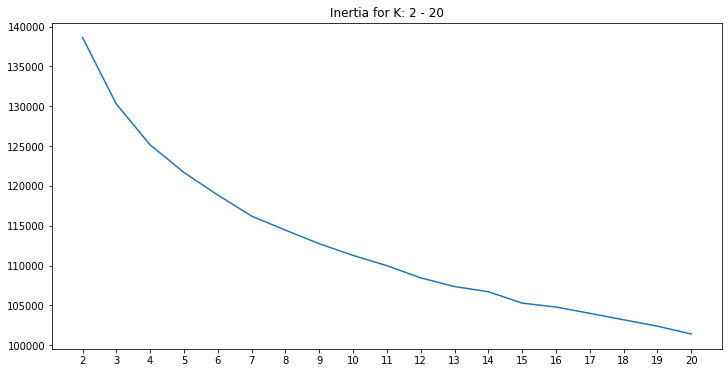

In [ ]:
plt.figure(figsize=(12, 6))
plt.title("Inertia for K: 2 - 20")
plt.plot(list(range(2, 21)), errors)
plt.xticks(list(range(2, 21)))
plt.show()

- **inertia를 기준으로 했을 때 최적의 K는 4입니다.**

### 문제 20. 최적의 클러스터 개수 찾기 4

- 이번에는 inertia 대신에 silhouette score를 이용하여 최적의 K를 찾아봅시다.

In [ ]:
scores = []

for K in range(2, 21):
    temp_model = KMeans(n_clusters=K)
    preds = temp_model.fit_predict(data2)
    scores.append(silhouette_score(data2, preds))

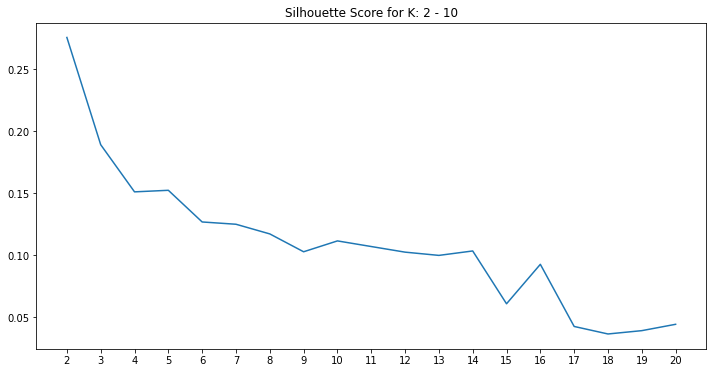

In [ ]:
plt.figure(figsize=(12, 6))
plt.title("Silhouette Score for K: 2 - 10")
plt.plot(list(range(2, 21)), scores)
plt.xticks(list(range(2, 21)))
plt.show()

- **silhouette을 기준으로 했을 때 최적의 K는 2입니다.**

### 문제 21. Hierarchical Clustering 돌려보기

- hierarchical clustering은 K-means와 전혀 다른 방법으로 동작합니다.

- hierarchical clustering은 distance measure와 linkage method를 변경하는 것으로 다양한 형태의 클러스터를 판별할 수 있습니다.

In [ ]:
# hierarchical clustering 함수를 scikit-learn에서 불러오기
from sklearn.cluster import AgglomerativeClustering

hierarchical_model = AgglomerativeClustering()
preds = hierarchical_model.fit_predict(data2)
preds

array([0, 0, 0, ..., 0, 0, 0])

In [ ]:
# 성능 측정을 위해 silhouette score를 계산합니다.
score = silhouette_score(data2, preds)
print("Silhouette Score: %.4f" % score)

Silhouette Score: 0.2813


### 문제 22. linkage 바꿔보기

- Hierarchical clustering은 linkage(연결 방식)을 변경하여 댜양한 형태의 데이터를 파악할 수 있습니다.

- 각 방식을 scikit-learn으로 구현하여 봅시다.

In [ ]:
# clustering model with various linkage method
model_single = AgglomerativeClustering(linkage="single")
model_average = AgglomerativeClustering(linkage="average")
model_complete = AgglomerativeClustering(linkage="complete")
model_ward = AgglomerativeClustering(linkage="ward") # default

pred_single = model_single.fit_predict(data2)
pred_average = model_average.fit_predict(data2)
pred_complete = model_complete.fit_predict(data2)
pred_ward = model_ward.fit_predict(data2)

### 문제 23. 성능 비교

- scikit-learn이 제공하는 4가지의 linkage 방법을 비교하여 성능을 확인하여 봅니다.

In [ ]:
# 성능 측정을 위해 silhouette score를 계산합니다.
score_single = silhouette_score(data2, pred_single)
score_average = silhouette_score(data2, pred_average)
score_complete = silhouette_score(data2, pred_complete)
score_ward = silhouette_score(data2, pred_ward)
print("Silhouette Score with single linkage: %.4f" % score_single)
print("Silhouette Score with average linkage: %.4f" % score_average)
print("Silhouette Score with complete linkage: %.4f" % score_complete)
print("Silhouette Score with ward linkage: %.4f" % score_ward)

Silhouette Score with single linkage: 0.6098
Silhouette Score with average linkage: 0.6837
Silhouette Score with complete linkage: 0.6837
Silhouette Score with ward linkage: 0.2872


### 문제 24. distance measure 바꿔보기

- Hierarchical clustering의 장점 중에 하나는 다양한 거리 함수를 사용할 수 있다는 것입니다.

- "affinity=" 파라미터를 변경하여 다른 거리 함수로 클러스터링을 시도하고 성능을 비교하여 봅시다.

- "ward linkage"는 euclidean distance만 가능하므로, linkage는 average로 변경하여 구현합니다.

In [ ]:
# hierarchical clustering
model_l1 = AgglomerativeClustering(affinity="manhattan", linkage="average")
model_l2 = AgglomerativeClustering(affinity="euclidean", linkage="average") # default
model_cos = AgglomerativeClustering(affinity="cosine", linkage="average")

# prediction
pred_l1 = model_l1.fit_predict(data2)
pred_l2 = model_l2.fit_predict(data2)
pred_cos = model_cos.fit_predict(data2)

### 문제 25. 성능 비교

In [ ]:
# 성능 측정을 위해 silhouette score를 계산합니다.
score_l1 = silhouette_score(data, pred_l1)
score_l2 = silhouette_score(data, pred_l2)
score_cos = silhouette_score(data, pred_cos)

print("Silhouette Score with L1 distance: %.4f" % score_l1)
print("Silhouette Score with L2 distance: %.4f" % score_l2)
print("Silhouette Score with cosine distance: %.4f" % score_cos)

Silhouette Score with L1 distance: 0.7426
Silhouette Score with L2 distance: 0.7606
Silhouette Score with cosine distance: -0.1978


## Item-level 바꿔보기 aisles -> products

- 지금의 데이터셋은 고객들이 구매한 아이템이 속한 135개의 aisles로 고객 정보를 표현했다면, 더 세부적인 정보를 포함하고 있는 products 단위로 변경하여 같은 프로세스를 진행해봅니다.

- products는 굉장히 많은 품목이 있어, feature vector의 차원이 엄청나게 커집니다.


- 이렇게 고차원 데이터를 클러스터링에 사용할 경우, "Curse of Dimensionality" 문제로 인해 엄청난 성능 저하가 발생할 수 있습니다.

- 따라서, 생성된 데이터를 PCA(Principal Component Analysis)를 사용하여 저차원 데이터로 감소시킨 후 클러스터링을 수행하여 봅니다.

### 문제 26. (RECAP) Customer 정의하기

- 이번엔 데이터를 products 단위로 표현해봅니다.

In [ ]:
# pd.crosstab 함수를 이용하여 데이터를 user_id당 product 구매 빈도로 변환합니다.
data = pd.crosstab(temp.user_id, temp.product_name)
data

product_name,#2 Coffee Filters,#4 Natural Brown Coffee Filters,0 Calorie Fuji Apple Pear Water Beverage,0% Fat Black Cherry Greek Yogurt y,0% Fat Blueberry Greek Yogurt,0% Fat Free Organic Milk,0% Fat Organic Greek Vanilla Yogurt,0% Fat Strawberry Greek Yogurt,0% Fat Superfruits Greek Yogurt,0% Greek Strained Yogurt,...,of Hanover 100 Calorie Pretzels Mini,of Norwich Original English Mustard Powder Double Superfine,smartwater® Electrolyte Enhanced Water,vitaminwater® XXX Acai Blueberry Pomegranate,with Bleach Disinfectant Cleanser Scratch Free Lavender Fresh,with Crispy Almonds Cereal,with Dawn Action Pacs Fresh Scent Dishwasher Detergent Pacs,with Olive Oil Mayonnaise Dressing,with Sweet & Smoky BBQ Sauce Cheeseburger Sliders,with Xylitol Minty Sweet Twist 18 Sticks Sugar Free Gum
user_id,,,,,,,,,,,,,,,,,,,,,
30,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
55,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
56,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
66,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
79,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
206162,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
206171,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
206177,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### 문제 27. PCA로 차원 감소시키기

- PCA를 사용하여 16738차원이나 되는 feature vector의 차원을 감소 시킵니다.

- scikit-learn에는 2가지의 PCA 구현체가 있습니다.
> PCA는 dense matrix를 사용할 때 적합합니다.
> truncatedSVD는 sparse matrix를 사용할 때 적합합니다.

- 현재 데이터는 sparse matrix이기 때문에, truncatedSVD를 사용하여 dimensionality reduction을 수행합니다.

- 감소할 차원은 기본값이 100차원으로 일단 수행합니다. (추후에 더 많은 실험을 해보시기 바랍니다!)

In [ ]:
# scikit-learn에서 PCA 불러오기
#from sklearn.decomposition import PCA  # 이거 말고 
from sklearn.decomposition import TruncatedSVD # 이것입니다.

tsvd = TruncatedSVD(n_components=100) # 100차원으로 변환
reduced_data = tsvd.fit_transform(data)
reduced_data.shape

(9477, 100)

### 문제 28. K-means 클러스터링 적용하기

In [ ]:
# scikit-learn에서 Kmeans를 불러옵니다.
from sklearn.cluster import KMeans

model = KMeans()
preds = model.fit_predict(reduced_data)
preds

array([1, 5, 2, ..., 6, 1, 1], dtype=int32)

In [ ]:
# 성능 측정을 위해 silhouette score를 불러옵니다
from sklearn.metrics import silhouette_score

score = silhouette_score(reduced_data, preds)
print("Silhouette Score: %.4f" % score)

Silhouette Score: 0.1924


### 문제 29. 최적의 클러스터 개수 찾기 5

- Kmeans는 K 개수에 따라 성능 편차가 심합니다.

- 최적의 K를 구하는 방법엔 어떤 것들이 있을까요?

In [ ]:
# inertia(Kmeans의 objective function값)을 계산해서 K값이 변화함에 따라 inertia의 변화가 가장 커지는 K를 찾습니다.
# K의 범위는 확인하고 싶은 모든 범위를 지정하면 됩니다. 실습에서는 2 ~ 20으로 하겠습니다.

errors = []

for K in range(2, 21):
    temp_model = KMeans(n_clusters=K)
    temp_model.fit(reduced_data)
    sse = temp_model.inertia_
    errors.append(sse)

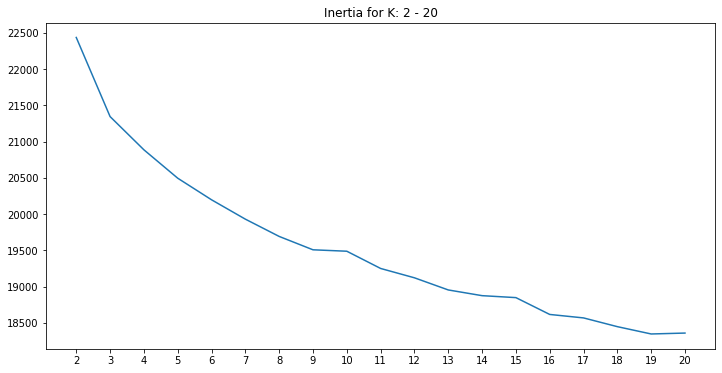

In [ ]:
plt.figure(figsize=(12, 6))
plt.title("Inertia for K: 2 - 20")
plt.plot(list(range(2, 21)), errors)
plt.xticks(list(range(2, 21)))
plt.show()

- **inertia를 기준으로 했을 때 최적의 K는 3입니다.**

### 문제 30. 최적의 클러스터 개수 찾기 6

- 이번에는 inertia 대신에 silhouette score를 이용하여 최적의 K를 찾아봅시다.

In [ ]:
scores = []

for K in range(2, 21):
    temp_model = KMeans(n_clusters=K)
    preds = temp_model.fit_predict(reduced_data)
    scores.append(silhouette_score(reduced_data, preds))

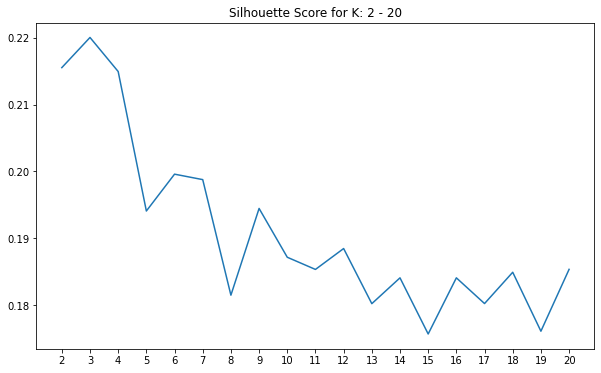

In [ ]:
plt.figure(figsize=(10, 6))
plt.title("Silhouette Score for K: 2 - 20")
plt.plot(list(range(2, 21)), scores)
plt.xticks(list(range(2, 21)))
plt.show()

- **silhouette을 기준으로 했을 때 최적의 K는 3입니다.**

### 문제 31. Hierarchical Clustering 돌려보기

- hierarchical clustering은 K-means와 전혀 다른 방법으로 동작합니다.

- hierarchical clustering은 distance measure와 linkage method를 변경하는 것으로 다양한 형태의 클러스터를 판별할 수 있습니다.

In [ ]:
# hierarchical clustering 함수를 scikit-learn에서 불러오기
from sklearn.cluster import AgglomerativeClustering

hierarchical_model = AgglomerativeClustering()
preds = hierarchical_model.fit_predict(reduced_data)
preds

array([0, 0, 0, ..., 0, 0, 0])

In [ ]:
# 성능 측정을 위해 silhouette score를 계산합니다.
score = silhouette_score(reduced_data, preds)
print("Silhouette Score: %.4f" % score)

Silhouette Score: 0.1890


### 문제 32. linkage 바꿔보기

- Hierarchical clustering은 linkage(연결 방식)을 변경하여 댜양한 형태의 데이터를 파악할 수 있습니다.

- 각 방식을 scikit-learn으로 구현하여 봅시다.

In [ ]:
# clustering model with various linkage method
model_single = AgglomerativeClustering(linkage="single")
model_average = AgglomerativeClustering(linkage="average")
model_complete = AgglomerativeClustering(linkage="complete")
model_ward = AgglomerativeClustering(linkage="ward") # default

pred_single = model_single.fit_predict(reduced_data)
pred_average = model_average.fit_predict(reduced_data)
pred_complete = model_complete.fit_predict(reduced_data)
pred_ward = model_ward.fit_predict(reduced_data)

### 문제 33. 성능 비교

- scikit-learn이 제공하는 4가지의 linkage 방법을 비교하여 성능을 확인하여 봅니다.

In [ ]:
# 성능 측정을 위해 silhouette score를 계산합니다.
score_single = silhouette_score(reduced_data, pred_single)
score_average = silhouette_score(reduced_data, pred_average)
score_complete = silhouette_score(reduced_data, pred_complete)
score_ward = silhouette_score(reduced_data, pred_ward)
print("Silhouette Score with single linkage: %.4f" % score_single)
print("Silhouette Score with average linkage: %.4f" % score_average)
print("Silhouette Score with complete linkage: %.4f" % score_complete)
print("Silhouette Score with ward linkage: %.4f" % score_ward)

Silhouette Score with single linkage: 0.5967
Silhouette Score with average linkage: 0.6210
Silhouette Score with complete linkage: 0.5367
Silhouette Score with ward linkage: 0.1890


### 문제 34. distance measure 바꿔보기

- Hierarchical clustering의 장점 중에 하나는 다양한 거리 함수를 사용할 수 있다는 것입니다.

- "affinity=" 파라미터를 변경하여 다른 거리 함수로 클러스터링을 시도하고 성능을 비교하여 봅시다.

- "ward linkage"는 euclidean distance만 가능하므로, linkage는 average로 변경하여 구현합니다.

In [ ]:
# hierarchical clustering
model_l1 = AgglomerativeClustering(affinity="manhattan", linkage="average")
model_l2 = AgglomerativeClustering(affinity="euclidean", linkage="average") # default
model_cos = AgglomerativeClustering(affinity="cosine", linkage="average")

# prediction
pred_l1 = model_l1.fit_predict(reduced_data)
pred_l2 = model_l2.fit_predict(reduced_data)
pred_cos = model_cos.fit_predict(reduced_data)

### 문제 35. 성능 비교

In [ ]:
# 성능 측정을 위해 silhouette score를 계산합니다.
score_l1 = silhouette_score(reduced_data, pred_l1)
score_l2 = silhouette_score(reduced_data, pred_l2)
score_cos = silhouette_score(reduced_data, pred_cos)

print("Silhouette Score with L1 distance: %.4f" % score_l1)
print("Silhouette Score with L2 distance: %.4f" % score_l2)
print("Silhouette Score with cosine distance: %.4f" % score_cos)

Silhouette Score with L1 distance: 0.6210
Silhouette Score with L2 distance: 0.6210
Silhouette Score with cosine distance: -0.3522
